## Libraries

In [1]:
import pandas as pd
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import CountVectorizer
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_json("mobygames.json")

## Separating games based on platforms

In [3]:
platforms = ['PlayStation', 'Xbox', 'Xbox 360']

In [4]:
def check_platforms(x):
    for platform in x:
        if platform in platforms:
            return True
    return False

In [5]:
df['platforms'] = df.releases.apply(lambda x: [i['name'] for i in x])
df['check'] = df.platforms.apply(check_platforms)
filtered_df = df[df['check'] == True]
filtered_df['release_date'] = filtered_df.releases.apply(lambda x: min([pd.to_datetime(i['release_date']) for i in x if i['name'] in platforms]))
filtered_df = filtered_df[['name', 'id', 'description', 'release_date', 'platforms']]
filtered_df.reset_index(drop= True, inplace= True)

In [61]:
filtered_df

,name,id,description,release_date,platforms
0,The X-Files Game,1,As an extension of one of the most long-runnin...,1999-01-01,"[Macintosh, PlayStation, Windows]"
1,Sid Meier's Civilization II,15,Starting out with just a single unit and knowl...,1998-12-23,"[Macintosh, PlayStation, Windows 3.x]"
2,The Three Stooges,27,"Stars of television and cinema, and now stars ...",2003-01-01,"[Amiga, Apple IIgs, Commodore 64, DOS, Game Bo..."
3,Quarantine,96,"In Quarantine, you play the part of a taxi dri...",1996-02-16,"[3DO, DOS, PlayStation, SEGA Saturn]"
4,Robotron: 2084,102,"You are a mutant human, who by some freak of n...",2006-01-06,"[Antstream, Apple II, Arcade, Atari 5200, Atar..."
...,...,...,...,...,...
12998,Chivas 1-2-3: Destiny! Unmei o Kaeru Mono!,203951,前代未聞！借金返済RPG！？\nストーリーはなんと全9話＋α話！「戦闘」や「バイト」で金を稼...,2000-01-06,[PlayStation]
12999,Fantastep,203952,絵本の世界を救うのはあなたです･･･。\n不思議な絵本を手に入れた主人公（ぼく）が、絵本の世...,1997-04-25,"[PlayStation, SEGA Saturn]"
13000,Tiger Storm,203983,Tiger Storm puts you in control of the most ad...,2009-10-30,[Xbox 360]
13001,Derby Stallion,204007,Derby Stallion enters the 5th generation of co...,1997-07-17,"[PlayStation, SEGA Saturn]"


In [6]:
del df

## Removing descriptions which are not in English

`Comparing libraries for language detection`

##### 1. langdetect

In [155]:
from langdetect import detect
filtered_df['lang'] = filtered_df.description.apply(detect)

In [156]:
filtered_df.lang.value_counts()

en    13001
es        1
et        1
Name: lang, dtype: int64

~ Not accurate at all

##### 2. langid

In [7]:
import langid
filtered_df['lang2'] = filtered_df.description.apply(lambda x: langid.classify(x)[0])

In [27]:
filtered_df.lang2.value_counts()

en    12953
ja       42
la        4
de        2
es        1
nl        1
Name: lang2, dtype: int64

~ Pretty accurate results

In [30]:
filtered_df[filtered_df.lang2 == 'ja'][:5]  # japanese

,name,id,description,release_date,lang,lang2
11718,Gaball Screen,143261,音楽は小室哲哉と久保こーじがプロデュース。 \n宇都宮隆をはじめ全8組のアーティストによる...,1996-12-06,en,ja
12827,Omise de Tensyu,200887,店づくりRPG\n店主を目指して冒険に出よう\n世界中を冒険して職業カードを探し出そう。カー...,1999-04-08,en,ja
12828,Neorude,200888,主人公を直接操作せず、間接的に指導、導き、謎を解いていく新感覚「リーディングRPG」。\n戦...,1997-05-09,en,ja
12829,Neorude 2,200889,ダンジョンの数が大幅に増加。街も加わり世界がグッと広がった！\n前作のデータでシナリオが変化...,1997-11-20,en,ja
12830,Neorude: Kizamareta Monshō,200890,リーディングRPGの最高峰ついに登場！\n\n個性溢れる３人の主人公と一緒にダイナミックで神...,1999-12-16,en,ja


In [34]:
filtered_df[(filtered_df.lang2 != 'en') & (filtered_df.lang2 != 'ja')].description.values  # languages other than english and japanese

array(['Lips: Canta en Español is a localized version of Lips: Number One Hits for Spanish-speaking countries. The game itself is identical to Number One Hits, but the tracklist consists entirely of Spanish songs. Downloadable content from other Lips games can be carried over and songs can be imported by swapping the discs. The disc comes with 35 songs:* Amaral - El Universo Sobre Mi\n\nAmaral - Sin Ti No Soy Nada\nAventura - Obsesión\nBebe - Malo\nCarlos Baute con Marta Sánchez - Colgando En Tus Manos\nCeltas Cortos - 20 De Abril\nConchita - Nada Que Perder\nCoti - Antes Que Ver El Sol\nDani Mata - Lamento Boliviano\nDanza Invisible - Sabor De Amor\nDespistaos - Física O Química\nEfecto Mariposa y Javier Ojeda - No Me Creesv\nEl Arrebato - Dame Cariño\nElla Baila Sola - Amores De Barra\nExtremoduro - So Payaso\nFito y Los Fitipaldis - Por La Boca Vive El Pez\nFito y Los Fitipaldis - Soldadito Marinero\nHanna - Como La Vida\nHéroes Del Silencio - Entre Dos Tierras\nJarabe de Palo - La 

In [8]:
filtered_df = filtered_df[~filtered_df.description.str.contains('<')]  # removing description which contains a html tag (in our case: 1)

In [ ]:
filtered_df = filtered_df[filtered_df.lang2 == 'en'].drop(columns= ['lang', 'lang2']).reset_index(drop= True)
filtered_df.head()

## Preprocessing Descriptions

In [ ]:
nlp = spacy.load('en_core_web_sm', exclude= ['parser'])  # model for accuracy

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # removing any url
    doc = nlp(text.replace("-\n", "").replace("\n", " ").replace('|', '').replace('-', ''))
    tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'VERB']]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text.replace('  ', '')

In [ ]:
filtered_df['cleaned_description'] = filtered_df.description.apply(preprocess_text)

Removing duplicates

In [ ]:
filtered_df = filtered_df.drop_duplicates(subset= 'cleaned_description').reset_index(drop= True)

#### Occurence count of tokens

In [ ]:
desc = ' '.join(filtered_df.cleaned_description.to_list()).split()

In [ ]:
from collections import Counter
count = Counter(desc)

In [20]:
dict(sorted(count.items(), key= lambda x: x[1], reverse=True))

{'game': 16734,
 'player': 15040,
 'use': 7812,
 'mode': 6031,
 'term': 5072,
 'play': 4800,
 'character': 4758,
 'time': 4616,
 'include': 4023,
 'level': 3947,
 'enemy': 3741,
 'take': 3557,
 'product': 3520,
 '®': 3398,
 'feature': 3352,
 'system': 3238,
 'see': 3149,
 'download': 3132,
 'weapon': 2929,
 'control': 2709,
 'move': 2516,
 'get': 2379,
 'team': 2307,
 'make': 2248,
 'source': 2213,
 'item': 2195,
 'version': 2186,
 'attack': 2142,
 'point': 2117,
 'screen': 2100,
 'information': 2095,
 'race': 1938,
 'series': 1934,
 'need': 1848,
 'base': 1833,
 'world': 1831,
 'find': 1812,
 'mission': 1798,
 'fight': 1793,
 'apply': 1759,
 'story': 1704,
 'allow': 1612,
 'ability': 1598,
 'way': 1590,
 'gameplay': 1565,
 'set': 1549,
 'battle': 1544,
 'choose': 1544,
 'add': 1509,
 'action': 1502,
 'car': 1462,
 'fee': 1419,
 'place': 1413,
 'require': 1407,
 'activate': 1386,
 'go': 1379,
 'track': 1309,
 'multiplayer': 1289,
 'license': 1277,
 'health': 1257,
 'start': 1232,
 'col

In [ ]:
to_del = []
for key, val in dict(sorted(count.items(), key= lambda x: x[1], reverse=False)).items():
    if val < 20:
        to_del.append(key)

In [132]:
len(to_del)

12768

After analyzing `count`

In [ ]:
to_del += ['®', '™']  # keywords to be deleted

In [ ]:
filtered_df['cleaned_description'] = filtered_df.cleaned_description.apply(lambda x: ' '.join([i for i in x.split() if i not in to_del]))  # removing the keywords

Removing descriptions with less than 10 words

In [ ]:
filtered_df['check'] = filtered_df.cleaned_description.apply(lambda x: True if len(x.split()) < 10 else False)

In [136]:
filtered_df = filtered_df[~filtered_df['check'] == True].drop(columns= 'check').reset_index(drop= True)

In [138]:
filtered_df.to_csv('./moby_ps_ps2__xbox_xbox360.csv', index= False)

In [2]:
# filtered_df = pd.read_csv('./moby_ps_ps2__xbox_xbox360.csv')

In [137]:
filtered_df

,name,id,description,release_date,platforms,cleaned_description
0,The X-Files Game,1,As an extension of one of the most long-runnin...,1999-01-01,"[Macintosh, PlayStation, Windows]",extension television series time play eye fiel...
1,Sid Meier's Civilization II,15,Starting out with just a single unit and knowl...,1998-12-23,"[Macintosh, PlayStation, Windows 3.x]",start unit knowledge area challenge guide civi...
2,The Three Stooges,27,"Stars of television and cinema, and now stars ...",2003-01-01,"[Amiga, Apple IIgs, Commodore 64, DOS, Game Bo...",star television star video game order collect ...
3,Quarantine,96,"In Quarantine, you play the part of a taxi dri...",1996-02-16,"[3DO, DOS, PlayStation, SEGA Saturn]",play part taxi driver escape prison city deliv...
4,Robotron: 2084,102,"You are a mutant human, who by some freak of n...",2006-01-06,"[Antstream, Apple II, Arcade, Atari 5200, Atar...",human nature ability shoot energy pulse body d...
...,...,...,...,...,...,...
9601,Oozi: Earth Adventure - Episode 1,203762,Oozi: Earth Adventure is where classic platfor...,2011-03-25,[Xbox 360],platformer gameplay meet visual art story mode...
9602,Oozi: Earth Adventure - Episode 2,203792,Oozi: Earth Adventure is where classic platfor...,2011-11-25,[Xbox 360],platforming fun meet visual art lot ability do...
9603,Tiger Storm,203983,Tiger Storm puts you in control of the most ad...,2009-10-30,[Xbox 360],put control battle technology launch betray wo...
9604,Derby Stallion,204007,Derby Stallion enters the 5th generation of co...,1997-07-17,"[PlayStation, SEGA Saturn]",enter generation console horse management retu...


## ML Model

Converting the text

In [9]:
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(filtered_df[filtered_df.release_date < '2001-01-01'].cleaned_description)

Dimension Reduction and Normalization

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())

scaler = QuantileTransformer(output_distribution= 'normal')
features_normalized = scaler.fit_transform(reduced_features)


### Model Tuning

In [59]:
from sklearn.metrics import calinski_harabasz_score

param_ranges = {
    'kernel': ['rbf'],
    'nu': np.linspace(0.2, 0.7, 7),
    'gamma': np.logspace(-4, -1, 5),
    'degree': [1, 2, 3],
}

best_params = None
best_score = float('-inf')

param_combinations = np.array(np.meshgrid(*param_ranges.values())).T.reshape(-1, len(param_ranges))

for params in param_combinations:
    params = dict(zip(param_ranges.keys(), params))  # paramters combination

    model = OneClassSVM(kernel= params['kernel'], nu= float(params['nu']), gamma= float(params['gamma']),  # model
                        degree= int(params['degree']))

    model.fit(features_normalized)  # fitting the training data
    score = calinski_harabasz_score(features_normalized, model.predict(features_normalized))  # evaluating model performance on training data

    # check if the current score is better than the previous best
    if score > best_score:
        best_params = params
        best_score = score

In [60]:
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'kernel': 'rbf', 'nu': '0.3666666666666667', 'gamma': '0.1', 'degree': '1'}
Best Score:  9.182772615234951


In [61]:
model = OneClassSVM(kernel= best_params['kernel'], nu= float(best_params['nu']), gamma= float(best_params['gamma']),  # model
                    degree= int(best_params['degree']))
model.fit(features_normalized)

OneClassSVM(degree=1, gamma=0.1, nu=0.3666666666666667)

### Prediction

In [62]:
new_features = vectorizer.transform(filtered_df[(filtered_df.release_date >= '2001-01-01') & (filtered_df.release_date < '2002-01-01')].cleaned_description)
reduced_new_features = pca.fit_transform(new_features.toarray())
normalized_new_features = scaler.fit_transform(reduced_new_features)
novelty_scores = model.decision_function(normalized_new_features)
predictions = model.predict(normalized_new_features)

Saving our training and test data

In [63]:
training_df = filtered_df[filtered_df.release_date < '2001-01-01'].reset_index(drop= True)
training_df['reduced_feature1'] = reduced_features[:, 0]
training_df['reduced_feature2'] = reduced_features[:, 1]
training_df['normalized_feature1'] = features_normalized[:, 0]
training_df['normalized_feature2'] = features_normalized[:, 1]

test_df = filtered_df[(filtered_df.release_date >= '2001-01-01') & (filtered_df.release_date < '2002-01-01')].reset_index(drop= True)
test_df['reduced_feature1'] = reduced_new_features[:, 0]
test_df['reduced_feature2'] = reduced_new_features[:, 1]
test_df['normalized_feature1'] = normalized_new_features[:, 0]
test_df['normalized_feature2'] = normalized_new_features[:, 1]
test_df['predictions'] = predictions

# saving them
training_df.to_csv('train.csv', index= False)
test_df.to_csv('test.csv', index= False)

### Visualization

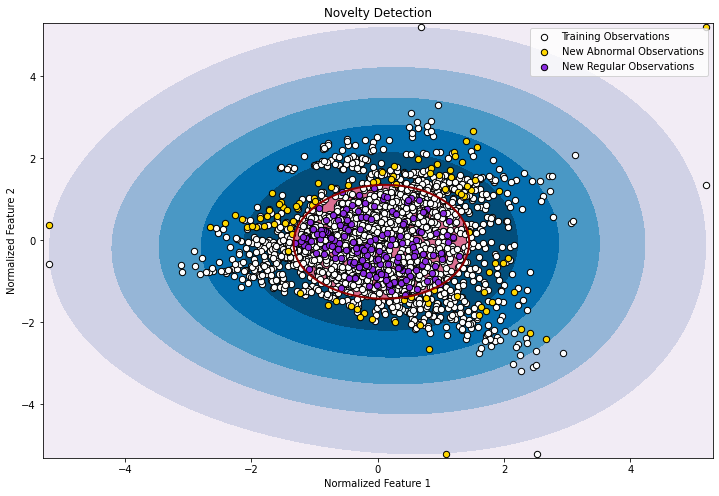

In [64]:
plt.figure(figsize= (12,8))  # figure size

X = test_df[['normalized_feature1', 'normalized_feature2']].to_numpy()
y = test_df['predictions'].to_numpy()

# grid of points to evaluate the contour plot
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# predictions for each point in the grid
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

# training points in white
plt.scatter(training_df['normalized_feature1'], training_df['normalized_feature2'], c= "white", s= 40, edgecolors="k", label= 'Training Observations')

# outlier points in red
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='gold', label='New Abnormal Observations', s= 40, edgecolors= 'k')

# normal points in blue
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blueviolet', label='New Regular Observations', s= 40, edgecolors= 'k')

plt.xlabel("Normalized Feature 1")
plt.ylabel("Normalized Feature 2")
plt.title("Novelty Detection")
plt.legend();